store classes in respective folder

In [1]:
import os
import shutil
import pandas as pd

# Define paths
csv_file = 'trainLabels_cropped.csv'
images_folder = 'final_images'
output_base_folder = 'organized_images'

# Read the CSV file
df = pd.read_csv(csv_file)

# Create output directories for each class (0-4)
for class_label in range(5):
    class_folder = os.path.join(output_base_folder, f'class_{class_label}')
    os.makedirs(class_folder, exist_ok=True)

# Move images to respective class folders
for _, row in df.iterrows():
    image_name = row['image'] + '.jpeg'  # assuming images have '.jpeg' extension; change if different
    class_label = row['level']

    source_path = os.path.join(images_folder, image_name)
    target_folder = os.path.join(output_base_folder, f'class_{class_label}')

    if os.path.exists(source_path):
        shutil.move(source_path, target_folder)
    else:
        print(f"Image not found: {source_path}")

print("Images successfully moved to their respective class folders.")

Images successfully moved to their respective class folders.


In [24]:
import os

def count_images_in_folders(base_path):
    class_counts = {}

    # Iterate through each class folder
    for class_label in range(5):
        class_folder = os.path.join(base_dir, f'class_{class_label}')

        if os.path.exists(class_folder):
            num_images = len([file for file in os.listdir(class_folder) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            print(f"Class {class_label} has {num_images} images.")
        else:
            print(f"Folder not found: {class_folder}")

# Example Usage:
base_dir = 'organized_images'  # Your base directory containing class folders
count_images_in_folders(base_path=base_dir)

Class 0 has 5288 images.
Class 1 has 4876 images.
Class 2 has 5288 images.
Class 3 has 5232 images.
Class 4 has 4248 images.


Image augmentation folder wise - elastic deformation

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
from scipy.ndimage import gaussian_filter, map_coordinates

# Elastic deformation function
def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted_image = np.empty_like(image)
    for i in range(image.shape[2] if image.ndim == 3 else 1):
        if image.ndim == 3:
            distorted_image[..., i] = map_coordinates(image[..., i], indices, order=1, mode='reflect').reshape(shape)
        else:
            distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

    return distorted_image

# Corrected augmentation function
def augment_single_class_folder(folder_path, class_label):
    augmented_data = []

    alpha = 34  # strength of deformation
    sigma = 4   # smoothness of deformation

    for image_file in os.listdir(folder_path):
        if not image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            continue

        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image_name, ext = os.path.splitext(image_file)

        # Perform augmentation
        for i in range(1, 3):
            augmented_image = elastic_transform(image=image_rgb, alpha=alpha, sigma=sigma)
            augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

            augmented_image_name = f"{image_name}_augmented_{i}{ext}"
            augmented_image_path = os.path.join(folder_path, augmented_image_name)

            cv2.imwrite(augmented_image_path, augmented_image_bgr)

            augmented_data.append({'image': f"{image_name}_augmented_{i}", 'level': class_label})

    # Generate new CSV file
    augmented_df = pd.DataFrame(augmented_data)
    augmented_df_path = os.path.join(folder_path, 'augmented_labels.csv')
    augmented_df.to_csv(augmented_df_path, index=False)

# Example usage:
folder_path = 'organized_images/class_3'
class_label = 3  # set the correct class label here
augment_single_class_folder(folder_path, class_label)

Data Augmentation - gaussian noise

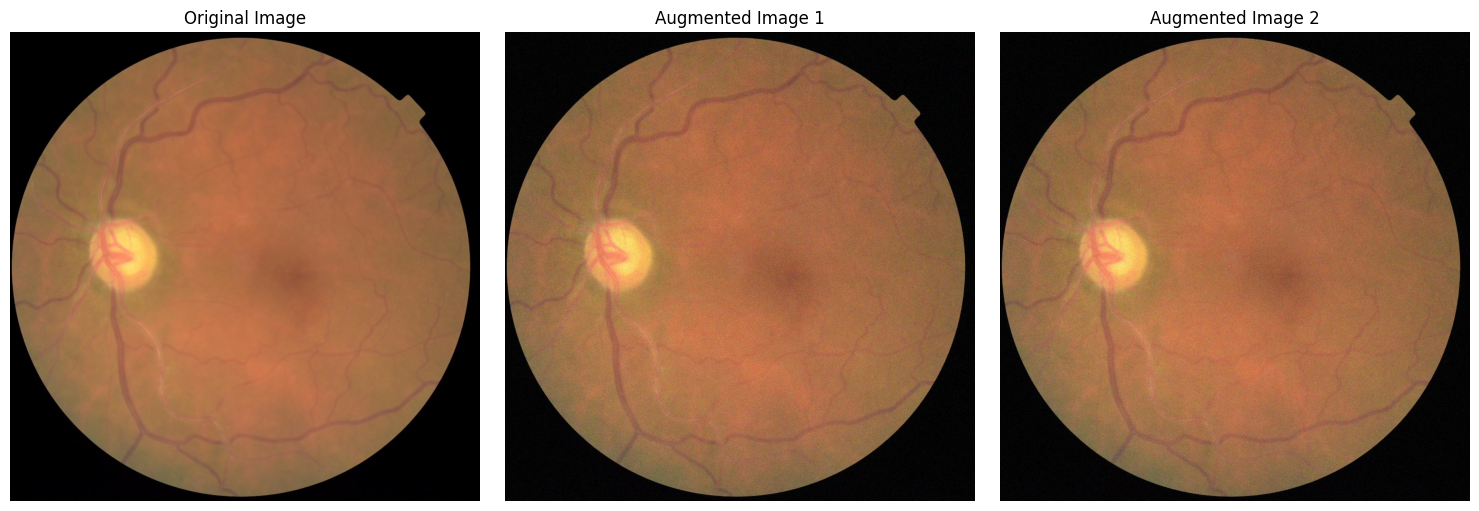

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Corrected Gaussian noise function
def gaussian_noise(image, mean=0, sigma=10):
    gaussian = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    noisy_image = cv2.add(image.astype(np.float32), gaussian)
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Main function to load image and perform augmentation
def gaussian_noise_augmentation(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create two augmented images
    augmented_image_1 = gaussian_noise(image_rgb, mean=0, sigma=10)
    augmented_image_2 = gaussian_noise(image_rgb, mean=0, sigma=10)

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_rgb)
    axes[0].set_title('Original Image')

    axes[1].imshow(augmented_image_1)
    axes[1].set_title('Augmented Image 1')

    axes[2].imshow(augmented_image_2)
    axes[2].set_title('Augmented Image 2')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
image_path = 'organized_images/class_1/15_left.jpeg'
gaussian_noise_augmentation(image_path=image_path)

In [16]:
import os
import cv2
import numpy as np
import pandas as pd

# Gaussian noise augmentation function
def add_gaussian_noise(image, sigma=10):
    gaussian_noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Function to augment images in a folder
def augment_folder_with_gaussian_noise(folder_path, class_label, sigma=10):
    augmented_data = []

    for image_file in os.listdir(folder_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            original_image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(original_image_path)

            # Apply Gaussian noise augmentation
            augmented_image = add_gaussian_noise(image, sigma=sigma)

            # New image name
            augmented_image_name = f"{os.path.splitext(image_file)[0]}_gaussian_noise_augmented{os.path.splitext(image_file)[1]}"
            augmented_image_path = os.path.join(folder_path, augmented_image_name)

            # Save augmented image
            cv2.imwrite(augmented_image_path, augmented_image)

            # Record augmented image name and label
            augmented_data.append({'image': augmented_image_name, 'level': class_label})

    # Generate new CSV file
    augmented_df = pd.DataFrame(augmented_data)
    augmented_csv_path = os.path.join(folder_path, 'gaussian_augmented_labels.csv')
    augmented_df.to_csv(augmented_csv_path, index=False)

    print(f"Gaussian augmentation done. Augmented images and CSV saved in: {folder_path}")

# Example usage:
folder_path = 'organized_images/class_4'  # Change to your specific folder
class_label = 4                           # Set your correct class label here

augment_folder_with_gaussian_noise(folder_path, class_label, sigma=10)

Gaussian augmentation done. Augmented images and CSV saved in: organized_images/class_4


Data augmentation - downsample class 0

In [18]:
import os
import shutil
import random
import pandas as pd

def downsample_class_with_csv(folder_path, output_folder, num_images_to_keep, class_label=0):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # List all images in original folder
    all_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.jpeg', '.jpg', '.png'))]

    print(f"Original number of images: {len(all_images)}")

    # Randomly select the images to keep
    images_to_keep = random.sample(all_images, num_images_to_keep)

    # Move images and store labels
    labels = []
    for img in images_to_keep:
        src_path = os.path.join(folder_path, img)
        dest_path = os.path.join(output_folder, img)
        shutil.move(src_path, dest_path)
        labels.append({'image': img, 'label': class_label})

    # Save labels to CSV file
    df_labels = pd.DataFrame(labels)
    csv_path = os.path.join(output_folder, 'downsampled_class_0_labels.csv')
    df_labels.to_csv(csv_path, index=False)

    print(f"Downsampled number of images: {len(images_to_keep)}")
    print(f"CSV file saved at: {csv_path}")

# Example usage:
class_0_folder = 'organized_images/class_0'
downsampled_folder = 'organized_images/class_0_downsampled'
num_to_keep = 5288  # Desired number of images to keep after downsampling

downsample_class_with_csv(class_0_folder, downsampled_folder, num_to_keep)

Original number of images: 25802
Downsampled number of images: 5288
CSV file saved at: organized_images/class_0_downsampled/downsampled_class_0_labels.csv


Generate label file

In [25]:
import os
import pandas as pd

def generate_labels_csv(base_dir, output_csv='labels.csv'):
    data = []

    # Loop through each class folder
    for folder_name in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)

        # Check if it's a directory and follows the naming convention "class_x"
        if os.path.isdir(folder_path) and folder_name.startswith('class_'):
            label = int(folder_name.split('_')[1])

            # Loop through each image file in the class folder
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    image_name = os.path.splitext(file_name)[0]
                    data.append({'image': image_name, 'label': label})

    # Create and save the CSV file
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Label CSV generated at: {output_csv}")

# Example usage:
base_directory = 'organized_images'
generate_labels_csv(base_directory, 'labels.csv')

Label CSV generated at: labels.csv


combining all images in final_image folder

In [27]:
import os
import shutil

def combine_images_to_single_folder(base_dir, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for sub_folder in sorted(os.listdir(base_dir)):
        sub_folder_path = os.path.join(base_dir, sub_folder)

        if os.path.isdir(sub_folder_path):
            for img_file in os.listdir(sub_folder_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    source_path = os.path.join(sub_folder_path, img_file)
                    target_path = os.path.join(output_folder, img_file)

                    shutil.copy2(source_path, target_path)

    print(f"All images successfully copied to '{output_folder}' folder.")

# Example Usage:
base_directory = 'organized_images'
output_directory = 'final_images'  # Correct variable name used here

combine_images_to_single_folder(base_directory, output_directory)

All images successfully copied to 'final_images' folder.


Dataset train test val for yolo

In [29]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# === Load CSV and Convert Labels to Integers ===
csv_path = "labels.csv"  # Update with actual CSV path
images_dir = "final_images"  # Folder containing all images
output_dir = "train_test_val"  # Output dataset directory

df = pd.read_csv(csv_path)
df["level"] = df["level"].astype(int)  # Convert labels to integers

# === Create Class-Based Folders in Train, Val, and Test Directories ===
for split in ["train", "val", "test"]:
    for class_id in range(5):  # Classes 0 to 4
        os.makedirs(os.path.join(output_dir, split, str(class_id)), exist_ok=True)

# === Train-Validation-Test Split (70%-20%-10%) ===
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42, stratify=df["level"])
val_df, test_df = train_test_split(temp_df, test_size=test_ratio / (val_ratio + test_ratio), random_state=42, stratify=temp_df["level"])

# === Move Images Into Class-Based Folders ===
def process_data(split_df, split_name):
    for _, row in split_df.iterrows():
        image_name = row["image"]
        label = int(row["level"])  # Ensure it's an integer

        # Define Image Paths
        image_path = os.path.join(images_dir, f"{image_name}.jpeg")  # Assuming all images are .jpeg
        if not os.path.exists(image_path):
            #print(f"⚠️ Image not found: {image_path}")
            continue  # Skip missing images

        # Move image to the appropriate class folder
        dest_image_path = os.path.join(output_dir, split_name, str(label), f"{image_name}.jpeg")
        shutil.copy(image_path, dest_image_path)
        #print(f"✅ Copied: {image_path} -> {dest_image_path}")  # Debugging message

# Process Train, Val, and Test Splits
process_data(train_df, "train")
process_data(val_df, "val")
process_data(test_df, "test")

print("✅ Dataset processing complete!")

✅ Dataset processing complete!
